Clearly state the goal of your project (what were you exploring? what scientific question did you ask?)
Describe the data.

What features (columns) did you have to work with? What features were you interested in?

Were the features numerical/categorical/text?

Was a lot of data missing or other problems? If so, what did you do to handle it?

How did features relate to each other, and the values that you were interested in?

Pictures are worth 1000s of words!

Clearly state the steps you took to build your model.

You should assume that your audience is new business owners seeking a loan and trying make decisions about what loan will give them the best rate when creating this presentation.

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [252]:
bank_data = pd.read_csv(r'C:\Users\shric\Desktop\Dai\case_studies\interest_rate\interest_rate\Data\bank_data.csv')
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,735-739,20000.0,20000.0,36.0
1,12.12,715-719,19200.0,19200.0,36.0
2,21.98,690-694,35000.0,35000.0,60.0
3,9.99,695-699,10000.0,9975.0,36.0
4,11.71,695-699,12000.0,12000.0,36.0


In [253]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
dtypes: float64(4), object(1)
memory usage: 97.7+ KB


In [254]:
bank_data.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length
count,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280661,41.265012
std,4.178007,7801.222483,7743.387861,9.933753
min,5.420000,1000.000000,-0.010000,36.000000
25%,10.160000,6000.000000,6000.000000,36.000000
50%,13.110000,10000.000000,10000.000000,36.000000
75%,15.800000,17000.000000,16000.000000,36.000000
max,24.890000,35000.000000,35000.000000,60.000000


In [255]:
# bank_data['fico_range'] = bank_data['fico_range'].str.split('-')


In [256]:
bank_data['fico_low'] = bank_data['fico_range'].str[:3].astype(float)
bank_data['fico_high'] = bank_data['fico_range'].str[4:].astype(float)

In [257]:
def calculate_mean(cell):
    numbers = [int(num) for num in cell.split('-')]
    return sum(numbers) / len(numbers)
# Apply the function to each cell in the column
bank_data['fico_mean'] = bank_data['fico_range'].apply(calculate_mean)

In [258]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
 5   fico_low                    2498 non-null   float64
 6   fico_high                   2498 non-null   float64
 7   fico_mean                   2498 non-null   float64
dtypes: float64(7), object(1)
memory usage: 156.3+ KB


In [259]:
bank_data.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean
0,8.90,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0
1,12.12,715-719,19200.0,19200.0,36.0,715.0,719.0,717.0
2,21.98,690-694,35000.0,35000.0,60.0,690.0,694.0,692.0
3,9.99,695-699,10000.0,9975.0,36.0,695.0,699.0,697.0
4,11.71,695-699,12000.0,12000.0,36.0,695.0,699.0,697.0


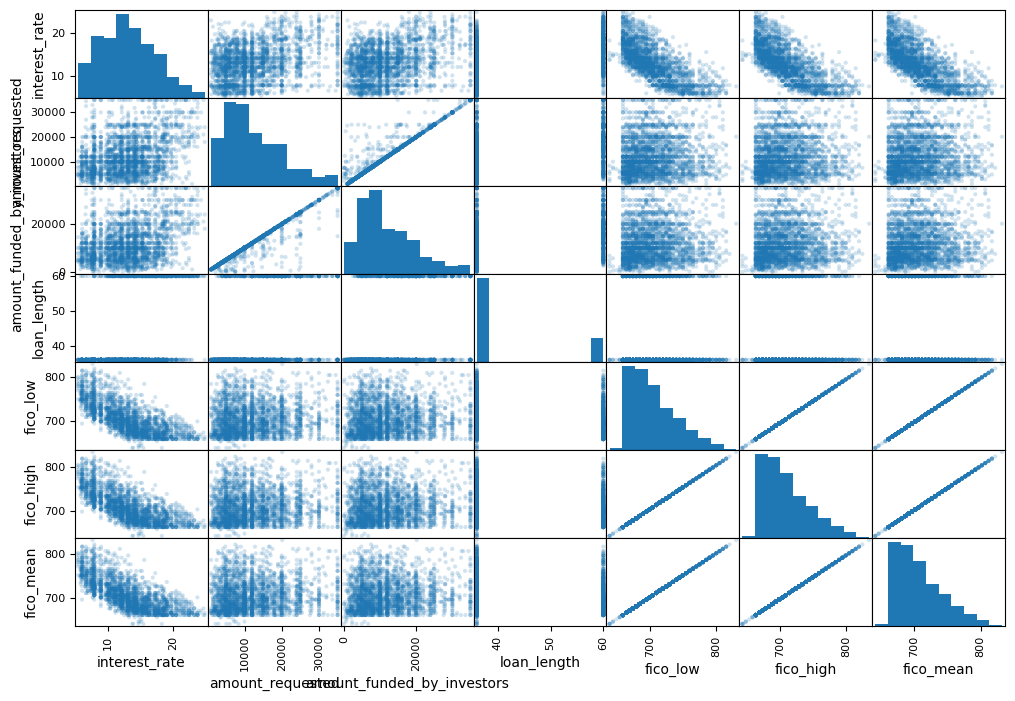

In [260]:
pd.plotting.scatter_matrix(bank_data, alpha=0.2, figsize=(12,8))
plt.show()

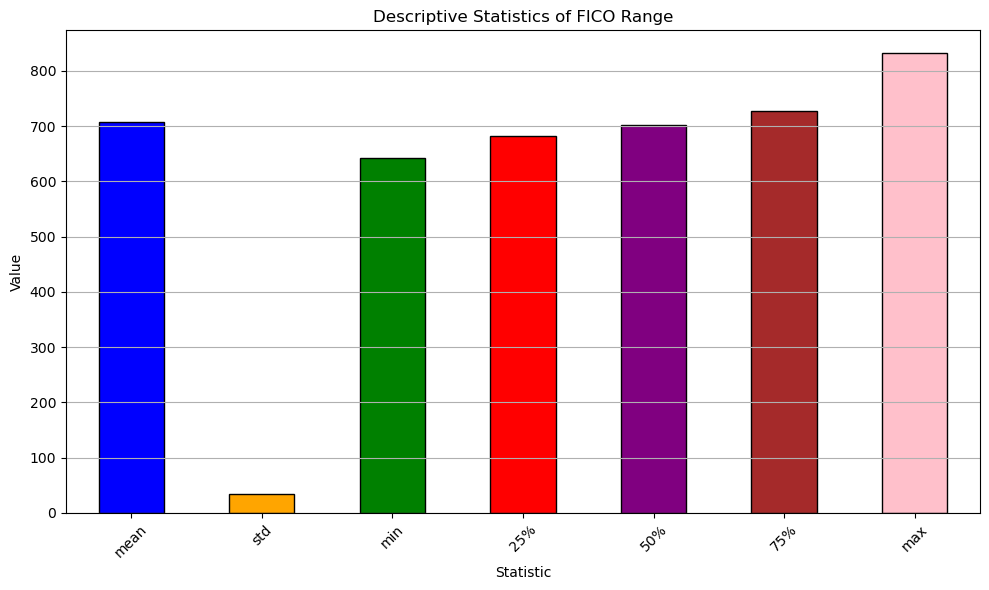

In [261]:
stats = bank_data['fico_mean'].describe().drop('count')
# Plot the descriptive statistics
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
plt.figure(figsize=(10, 6))
stats.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Descriptive Statistics of FICO Range')
plt.ylabel('Value')
plt.xlabel('Statistic')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [262]:
bank_data.head(1)

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean
0,8.9,735-739,20000.0,20000.0,36.0,735.0,739.0,737.0


In [263]:
interest_rate = bank_data
interest_rate_drop = interest_rate.drop(['interest_rate', 'fico_range', 'fico_low', 'fico_high'], axis = 1)

y = interest_rate['interest_rate']
X = interest_rate_drop
print(y)
print(X)


model = LinearRegression()
model.fit(X, y)


0        8.90
1       12.12
2       21.98
3        9.99
4       11.71
        ...  
2493    16.77
2494    14.09
2495    13.99
2496    12.42
2497    13.79
Name: interest_rate, Length: 2498, dtype: float64
      amount_requested  amount_funded_by_investors  loan_length  fico_mean
0              20000.0                    20000.00         36.0      737.0
1              19200.0                    19200.00         36.0      717.0
2              35000.0                    35000.00         60.0      692.0
3              10000.0                     9975.00         36.0      697.0
4              12000.0                    12000.00         36.0      697.0
...                ...                         ...          ...        ...
2493           30000.0                    29950.00         60.0      707.0
2494           16000.0                    16000.00         60.0      742.0
2495           10000.0                    10000.00         36.0      682.0
2496            6000.0                     600

LinearRegression()

In [264]:
X

,amount_requested,amount_funded_by_investors,loan_length,fico_mean
0,20000.0,20000.00,36.0,737.0
1,19200.0,19200.00,36.0,717.0
2,35000.0,35000.00,60.0,692.0
3,10000.0,9975.00,36.0,697.0
4,12000.0,12000.00,36.0,697.0
...,...,...,...,...
2493,30000.0,29950.00,60.0,707.0
2494,16000.0,16000.00,60.0,742.0
2495,10000.0,10000.00,36.0,682.0
2496,6000.0,6000.00,36.0,677.0


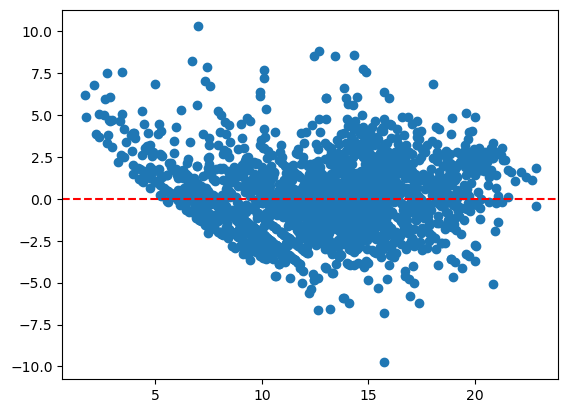

In [265]:
interest_rate_preds = model.predict(X)
resids = y - interest_rate_preds
plt.scatter(interest_rate_preds, resids)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

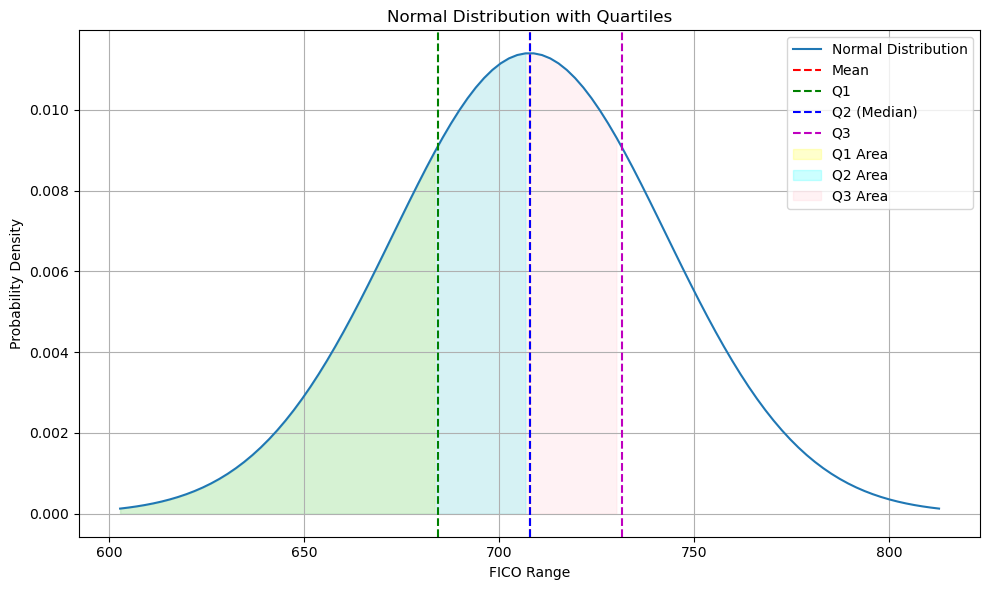

In [266]:
mean = bank_data['fico_mean'].mean()
std_dev = bank_data['fico_mean'].std()
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = norm.pdf(x, mean, std_dev)
# Calculate quartiles
q1 = norm.ppf(0.25, mean, std_dev)
q2 = norm.ppf(0.5, mean, std_dev)
q3 = norm.ppf(0.75, mean, std_dev)
# Plot the normal distribution and quartiles
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.axvline(x=mean, color='r', linestyle='--', label='Mean')
plt.axvline(x=q1, color='g', linestyle='--', label='Q1')
plt.axvline(x=q2, color='b', linestyle='--', label='Q2 (Median)')
plt.axvline(x=q3, color='m', linestyle='--', label='Q3')
plt.fill_between(x, y, where=(x <= q1), alpha=0.2, color='yellow', label='Q1 Area')
plt.fill_between(x, y, where=(x <= q2), alpha=0.2, color='cyan', label='Q2 Area')
plt.fill_between(x, y, where=(x <= q3), alpha=0.2, color='pink', label='Q3 Area')
plt.title('Normal Distribution with Quartiles')
plt.xlabel('FICO Range')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [267]:
y

array([0.00012665, 0.00015162, 0.00018085, 0.00021493, 0.0002545 ,
       0.00030024, 0.0003529 , 0.00041328, 0.00048222, 0.00056059,
       0.00064932, 0.00074932, 0.00086156, 0.00098698, 0.00112652,
       0.00128106, 0.00145147, 0.00163851, 0.00184287, 0.00206513,
       0.0023057 , 0.00256486, 0.00284269, 0.00313906, 0.00345362,
       0.00378578, 0.00413466, 0.00449914, 0.0048778 , 0.00526894,
       0.00567058, 0.00608046, 0.00649606, 0.00691463, 0.00733317,
       0.00774854, 0.00815742, 0.00855639, 0.00894197, 0.00931066,
       0.009659  , 0.00998365, 0.01028137, 0.01054915, 0.01078421,
       0.0109841 , 0.01114668, 0.01127018, 0.01135328, 0.01139506,
       0.01139506, 0.01135328, 0.01127018, 0.01114668, 0.0109841 ,
       0.01078421, 0.01054915, 0.01028137, 0.00998365, 0.009659  ,
       0.00931066, 0.00894197, 0.00855639, 0.00815742, 0.00774854,
       0.00733317, 0.00691463, 0.00649606, 0.00608046, 0.00567058,
       0.00526894, 0.0048778 , 0.00449914, 0.00413466, 0.00378

In [270]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize lists to store R2 for each fold
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X1[train_index], X1[test_index]  # Split features
    y_train, y_test = y1[train_index], y1[test_index]  # Split target variable
    # Initialize and fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Calculate R2 for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
# Calculate average R2 across all folds
avg_r2 = np.mean(r2_scores)
print("Average R2:", avg_r2)

Average R2: -6.371914938796408e-05


In [271]:
interest_rate_preds = model.predict(X)
resids = y - interest_rate_preds

plt.scatter(interest_rate_preds, resids)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

c:\Users\shric\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 4 features, but LinearRegression is expecting 1 features as input.

In [278]:
bank_data['Principal_Cash_Flow'] = round(bank_data['amount_funded_by_investors'] / bank_data['loan_length'], 2)
bank_data['Effective_Annual_Rate'] = round((bank_data['interest_rate'] / bank_data['loan_length']), 4)
bank_data['Interest_Cash_Flow'] = round((bank_data['Effective_Annual_Rate'] * bank_data['Principal_Cash_Flow']), 2)
bank_data['Monthly_Payment'] = bank_data['Principal_Cash_Flow'] + bank_data['Interest_Cash_Flow']
bank_data

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_low,fico_high,fico_mean,Principal_Cash_Flow,Effective_Annual_Rate,Interest_Cash_Flow,Total_Monthly_Cash_Flow,Monthly_Payment
0,8.90,735-739,20000.0,20000.00,36.0,735.0,739.0,737.0,555.56,0.2472,137.33,692.89,692.89
1,12.12,715-719,19200.0,19200.00,36.0,715.0,719.0,717.0,533.33,0.3367,179.57,712.90,712.90
2,21.98,690-694,35000.0,35000.00,60.0,690.0,694.0,692.0,583.33,0.3663,213.67,797.00,797.00
3,9.99,695-699,10000.0,9975.00,36.0,695.0,699.0,697.0,277.08,0.2775,76.89,353.97,353.97
4,11.71,695-699,12000.0,12000.00,36.0,695.0,699.0,697.0,333.33,0.3253,108.43,441.76,441.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,16.77,705-709,30000.0,29950.00,60.0,705.0,709.0,707.0,499.17,0.2795,139.52,638.69,638.69
2494,14.09,740-744,16000.0,16000.00,60.0,740.0,744.0,742.0,266.67,0.2348,62.61,329.28,329.28
2495,13.99,680-684,10000.0,10000.00,36.0,680.0,684.0,682.0,277.78,0.3886,107.95,385.73,385.73
2496,12.42,675-679,6000.0,6000.00,36.0,675.0,679.0,677.0,166.67,0.3450,57.50,224.17,224.17
